## 1. Importation des données et informations générales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
application_train = pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/application_train.csv', sep=',', encoding='ISO-8859-1')

In [3]:
print("application_train -  rows:",application_train.shape[0]," columns:", application_train.shape[1])

application_train -  rows: 307511  columns: 122


In [4]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


## 2. Feature engineering

In [5]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    
     # Encodage one-hot pour les autres colonnes catégorielles
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def application_train(num_rows=None, nan_as_category=False):
    # Lire les données à partir du CSV
    df = pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/application_train.csv', sep=',', encoding='ISO-8859-1')

    # Encodage binaire pour les colonnes catégorielles (0 ou 1; deux catégories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])

    # Encodage one-hot pour les autres colonnes catégorielles
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # Remplacer les valeurs NaN pour DAYS_EMPLOYED : 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

    # Création de nouvelles fonctionnalités (pourcentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    # Nettoyage
    gc.collect()

    return df


# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/bureau.csv', sep=',', encoding='ISO-8859-1')
    bb = pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/bureau_balance.csv', sep=',', encoding='ISO-8859-1')
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/previous_application.csv', sep=',', encoding='ISO-8859-1')
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos= pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/POS_CASH_balance.csv', sep=',', encoding='ISO-8859-1')
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/installments_payments.csv', sep=',', encoding='ISO-8859-1')
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc= pd.read_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/credit_card_balance.csv', sep=',', encoding='ISO-8859-1')
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


In [6]:
# Appeler les fonctions de prétraitement
train_df = application_train()           
bureau_agg_df = bureau_and_balance()               # bureau.csv et bureau_balance.csv
prev_app_agg_df = previous_applications()          # previous_application.csv
pos_cash_agg_df = pos_cash()                       # POS_CASH_balance.csv
installments_agg_df = installments_payments()      # installments_payments.csv
credit_card_agg_df = credit_card_balance()         # credit_card_balance.csv

# Fusionner les différents jeux de données avec 'train_test_df'
# Le DataFrame principal est `train_test_df`, et nous fusionnons chaque ensemble basé sur `SK_ID_CURR`.
train_df = train_df.merge(bureau_agg_df, on='SK_ID_CURR', how='left')
train_df = train_df.merge(prev_app_agg_df, on='SK_ID_CURR', how='left')
train_df = train_df.merge(pos_cash_agg_df, on='SK_ID_CURR', how='left')
train_df = train_df.merge(installments_agg_df, on='SK_ID_CURR', how='left')
train_df = train_df.merge(credit_card_agg_df, on='SK_ID_CURR', how='left')

# Gérer les valeurs infinies après la fusion
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [7]:
# Vérifier si SK_ID_CURR contient uniquement des valeurs uniques
unique_values = train_df['SK_ID_CURR'].nunique()

# Comparer avec le nombre total de lignes
total_values = len(train_df['SK_ID_CURR'])

if unique_values == total_values:
    print("Toutes les valeurs de SK_ID_CURR sont uniques.")
else:
    print(f"Il y a {total_values - unique_values} doublons dans SK_ID_CURR.")

Toutes les valeurs de SK_ID_CURR sont uniques.


In [8]:
# Sélectionner uniquement les colonnes numériques
colonnes_numeriques = train_df.select_dtypes(include=[np.number])

# Vérifier si des valeurs infinies existent dans les colonnes numériques
valeurs_infinies = np.isinf(colonnes_numeriques)

# Compter le nombre total de valeurs infinies
nombre_de_valeurs_infinies = valeurs_infinies.sum().sum()

# Compter le nombre de lignes contenant des valeurs infinies
lignes_infinies = valeurs_infinies.any(axis=1)  # Renvoie un tableau booléen par ligne
nombre_de_lignes_infinies = lignes_infinies.sum()

print(f"Nombre total de valeurs infinies : {nombre_de_valeurs_infinies}")
print(f"Nombre de lignes contenant des valeurs infinies : {nombre_de_lignes_infinies}")


Nombre total de valeurs infinies : 0
Nombre de lignes contenant des valeurs infinies : 0


## 3. EDA

### 3.1. Variable cible TARGET

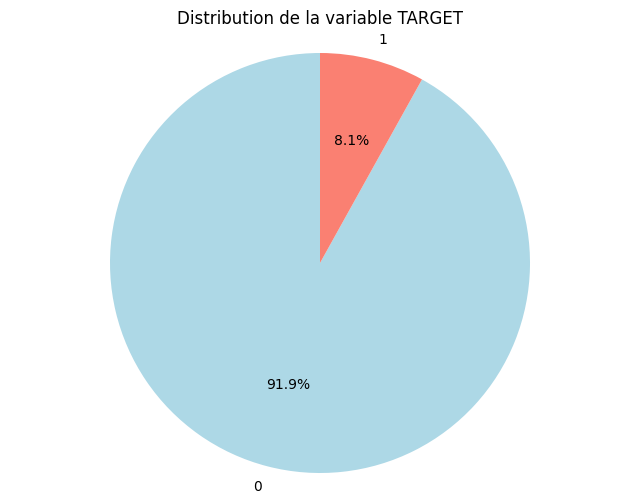

In [9]:
# Calculer la distribution de la variable TARGET
target_distribution = train_df['TARGET'].value_counts()

# Créer le camembert
plt.figure(figsize=(8, 6))
plt.pie(target_distribution, labels=target_distribution.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon'])
plt.title('Distribution de la variable TARGET')
plt.axis('equal')  
plt.show()

Ces données indiquent un problème de déséquilibre pour la variable Target, avec un nombre nettement supérieur de prêts remboursés à temps (91.9%) par rapport aux prêts non remboursés (8.1%). Pour corriger ce déséquilibre lors de l'utilisation de modèles d'apprentissage automatique plus avancés, nous pourrons ajuster la pondération des classes en fonction de leur fréquence dans les données.

### 3.2. Corrélations

In [10]:
# Calculer les corrélations avec la variable TARGET
corr_with_target = train_df.corr()['TARGET'].sort_values(ascending=False)

# Filtrer les variables ayant une corrélation significative avec TARGET
threshold = 0.05  # définir le seuil
significant_vars = corr_with_target[abs(corr_with_target) > threshold].index.tolist()

# Créer un sous-ensemble du DataFrame avec ces variables
df_significant = train_df[significant_vars]

# Calculer la matrice de corrélation pour ces variables
corr_matrix = df_significant.corr().abs()

# Supprimer les variables corrélées entre elles (Multicolinéarité)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Trouver les variables ayant une corrélation supérieure au seuil
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.7)]

# Supprimer les variables corrélées entre elles
df_reduced = df_significant.drop(columns=to_drop)

# Créer un DataFrame sans valeurs manquantes pour le calcul du VIF
X = df_reduced.dropna().assign(constant=1)

# Calculer les VIF pour chaque variable sur les données sans valeurs manquantes
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filtrer les variables ayant un VIF élevé (par exemple > 5)
final_vars = vif_data[vif_data['VIF'] < 5]['feature'].tolist()

# Supprimer la constante du résultat final si présente
if 'constant' in final_vars:
    final_vars.remove('constant')

# Les variables finales sélectionnées
print("Variables sélectionnées :", final_vars)

Variables sélectionnées : ['TARGET', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'CC_CNT_DRAWINGS_CURRENT_MAX', 'BURO_DAYS_CREDIT_MEAN', 'CC_AMT_BALANCE_MEAN', 'DAYS_BIRTH', 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 'BURO_CREDIT_ACTIVE_Active_MEAN', 'DAYS_EMPLOYED', 'REFUSED_DAYS_DECISION_MAX', 'CC_AMT_BALANCE_MIN', 'ACTIVE_DAYS_CREDIT_MEAN', 'CC_CNT_DRAWINGS_ATM_CURRENT_MAX', 'CC_MONTHS_BALANCE_MEAN', 'BURO_STATUS_1_MEAN_MEAN', 'CC_CNT_DRAWINGS_ATM_CURRENT_VAR', 'REGION_RATING_CLIENT_W_CITY', 'CC_AMT_DRAWINGS_CURRENT_MEAN', 'NAME_INCOME_TYPE_Working', 'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN', 'PREV_CODE_REJECT_REASON_SCOFR_MEAN', 'DAYS_LAST_PHONE_CHANGE', 'APPROVED_DAYS_DECISION_MIN', 'DAYS_ID_PUBLISH', 'REG_CITY_NOT_WORK_CITY', 'REFUSED_HOUR_APPR_PROCESS_START_MIN', 'CODE_GENDER', 'BURO_STATUS_C_MEAN_MEAN', 'NAME_EDUCATION_TYPE_Higher education', 'PREV_NAME_CONTRACT_STATUS_Approved_MEAN', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']


In [11]:
train_df_2 = train_df[final_vars]

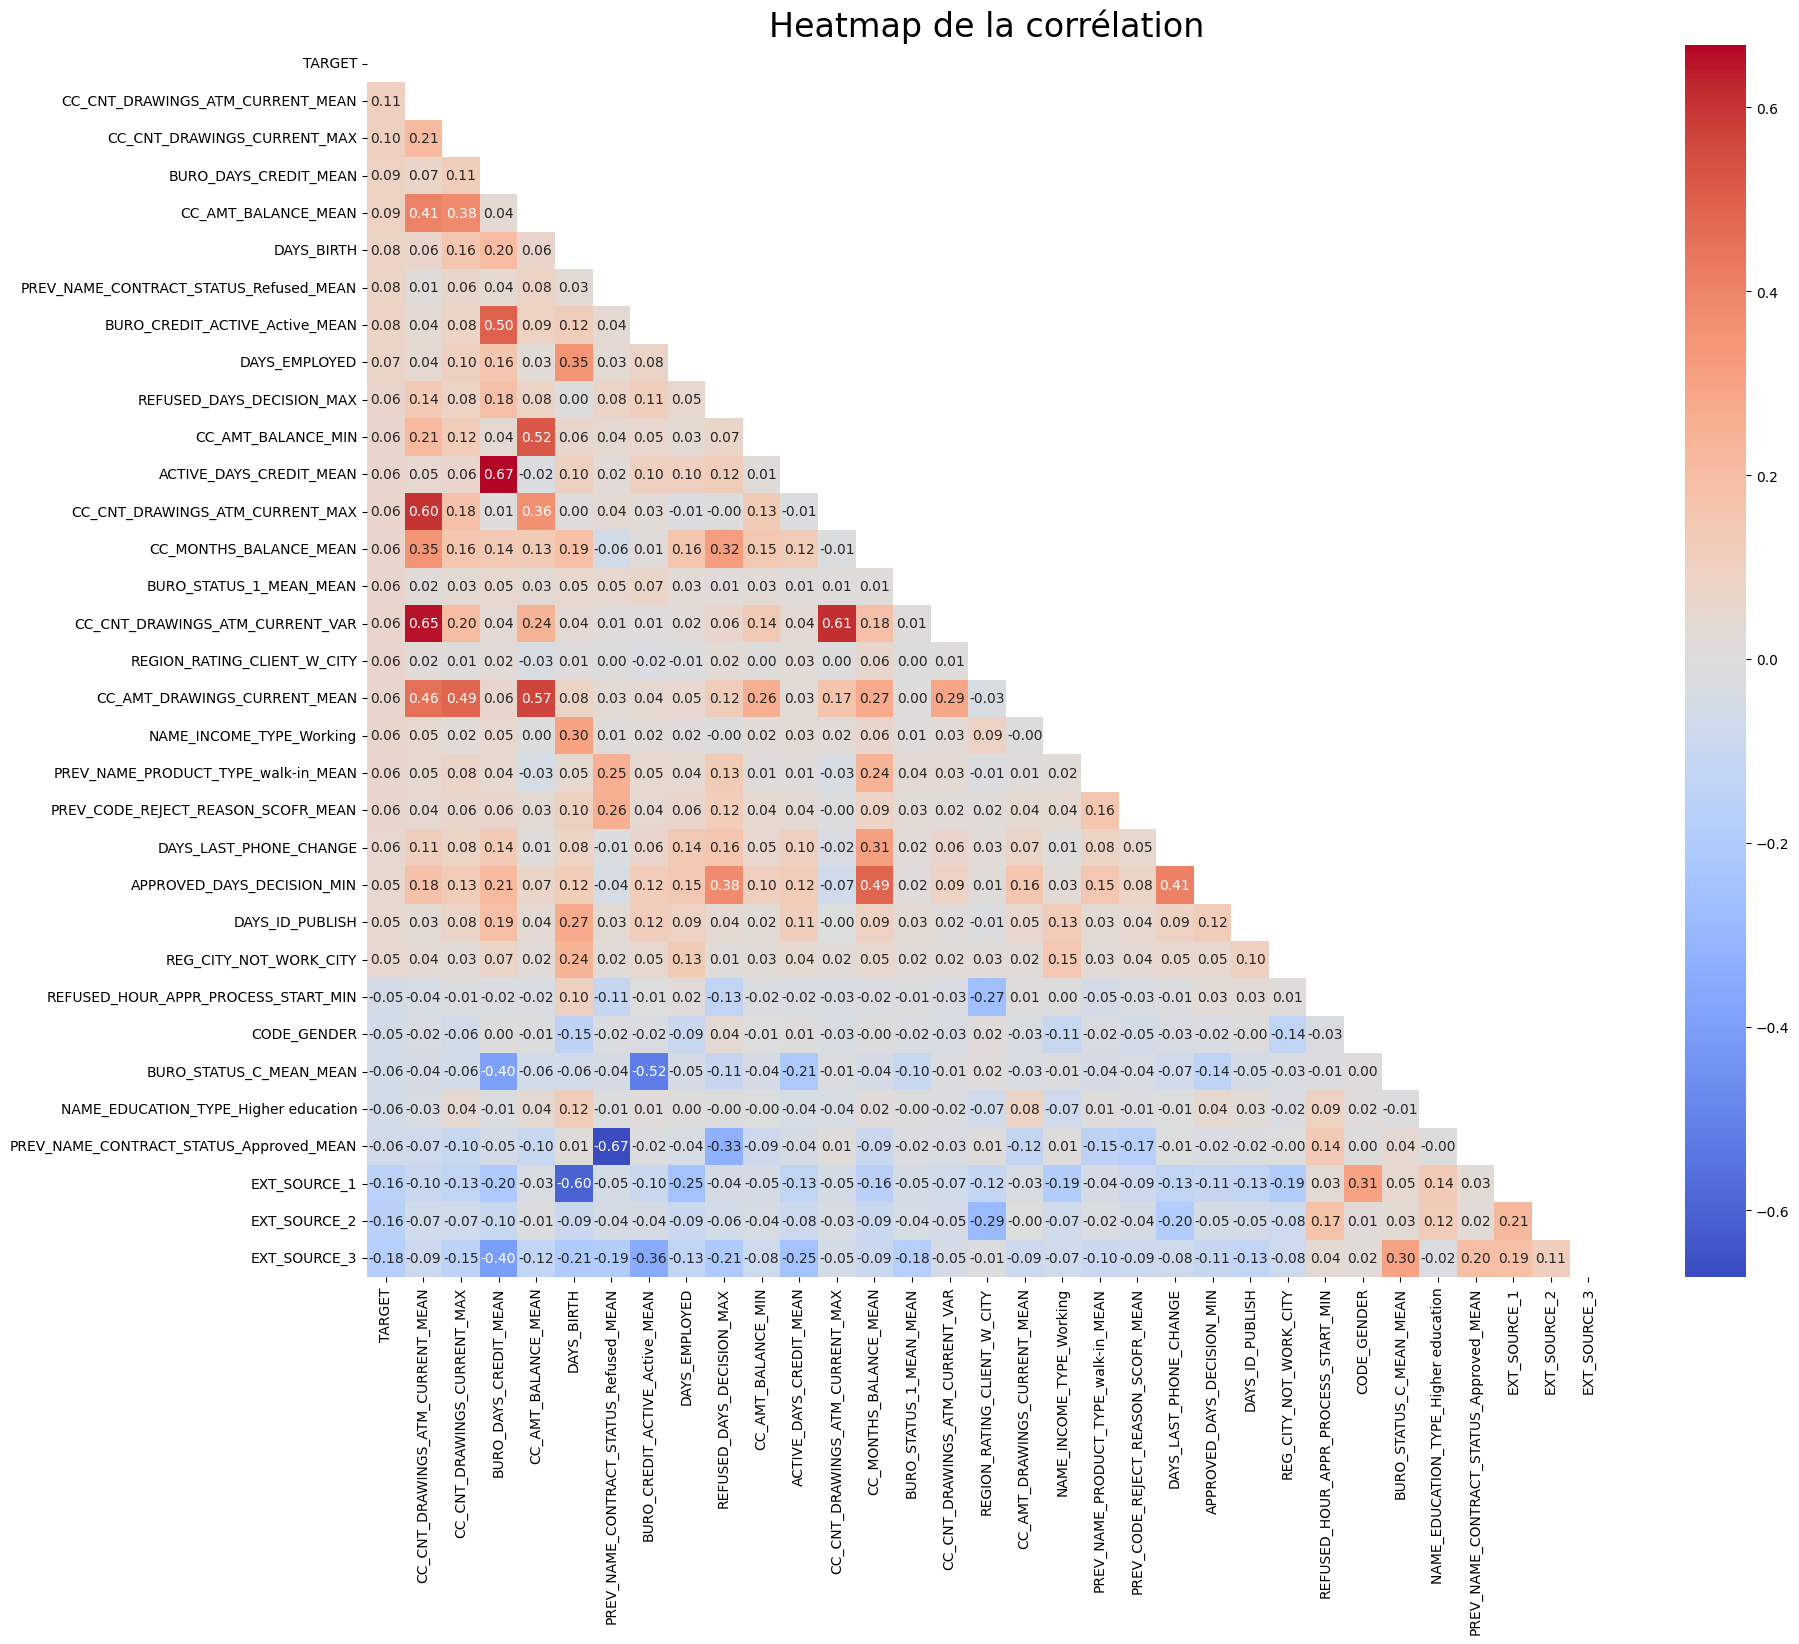

In [12]:
# Calculer la matrice de corrélation pour les variables sélectionnées
corr_matrix_2 = train_df_2.corr()

# Masquer la moitié inférieure de la matrice de corrélation
mask = np.triu(np.ones_like(corr_matrix_2, dtype=bool))

# Tracer la heatmap avec le masque
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix_2, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Heatmap de la corrélation", fontsize=24)
plt.show()

In [13]:
train_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Data columns (total 33 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   TARGET                                   307511 non-null  int64  
 1   CC_CNT_DRAWINGS_ATM_CURRENT_MEAN         61140 non-null   float64
 2   CC_CNT_DRAWINGS_CURRENT_MAX              86905 non-null   float64
 3   BURO_DAYS_CREDIT_MEAN                    263491 non-null  float64
 4   CC_AMT_BALANCE_MEAN                      86905 non-null   float64
 5   DAYS_BIRTH                               307511 non-null  int64  
 6   PREV_NAME_CONTRACT_STATUS_Refused_MEAN   291057 non-null  float64
 7   BURO_CREDIT_ACTIVE_Active_MEAN           263491 non-null  float64
 8   DAYS_EMPLOYED                            252137 non-null  float64
 9   REFUSED_DAYS_DECISION_MAX                100294 non-null  float64
 10  CC_AMT_BALANCE_MIN              

In [14]:
pd.set_option('display.max_columns', None)  # Affiche toutes les colonnes
pd.set_option('display.width', 1000)  # Largeur de l'affichage
train_df_2.describe()

,TARGET,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MAX,BURO_DAYS_CREDIT_MEAN,CC_AMT_BALANCE_MEAN,DAYS_BIRTH,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,DAYS_EMPLOYED,REFUSED_DAYS_DECISION_MAX,CC_AMT_BALANCE_MIN,ACTIVE_DAYS_CREDIT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_MONTHS_BALANCE_MEAN,BURO_STATUS_1_MEAN_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,REGION_RATING_CLIENT_W_CITY,CC_AMT_DRAWINGS_CURRENT_MEAN,NAME_INCOME_TYPE_Working,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,DAYS_LAST_PHONE_CHANGE,APPROVED_DAYS_DECISION_MIN,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,REFUSED_HOUR_APPR_PROCESS_START_MIN,CODE_GENDER,BURO_STATUS_C_MEAN_MEAN,NAME_EDUCATION_TYPE_Higher education,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
count,307511.000000,61140.000000,86905.000000,263491.000000,86905.000000,307511.000000,291057.000000,263491.000000,252137.000000,100294.000000,86905.000000,217150.000000,61140.000000,86905.000000,92231.000000,60693.000000,307511.000000,8.690500e+04,307511.000000,291057.000000,291057.00000,307510.000000,290065.000000,307511.000000,307511.000000,100294.000000,307511.000000,92231.000000,307511.000000,291057.000000,134133.000000,3.068510e+05,246546.000000
mean,0.080729,0.566241,6.803625,-1083.047110,71459.926952,-16036.995067,0.110902,0.412972,-2384.169325,-728.625042,10807.899707,-650.789789,3.995895,-19.523150,0.014199,2.040586,2.031521,1.391348e+04,0.516320,0.080552,0.00562,-962.858788,-1530.571334,-2994.202373,0.230454,11.603845,0.658370,0.330249,0.243448,0.748855,0.502130,5.143927e-01,0.510853
std,0.272419,0.880410,10.572428,563.327298,109056.518226,4363.988632,0.184348,0.308404,2338.360162,746.190402,45122.149552,495.737551,3.639161,16.775910,0.041683,6.686411,0.502737,2.661058e+04,0.499734,0.183439,0.04314,826.808487,862.867945,1509.450419,0.421124,3.309328,0.474284,0.262989,0.429164,0.262332,0.211062,1.910602e-01,0.194844
min,0.000000,0.000000,0.000000,-2922.000000,-2930.232558,-25229.000000,0.000000,0.000000,-17912.000000,-2922.000000,-420250.185000,-2922.000000,0.000000,-50.179775,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.00000,-4292.000000,-2922.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014568,8.173617e-08,0.000527
25%,0.000000,0.062993,0.000000,-1434.000000,0.000000,-19682.000000,0.000000,0.200000,-3175.000000,-1004.000000,0.000000,-871.500000,2.000000,-38.500000,0.000000,0.115351,2.000000,0.000000e+00,0.000000,0.000000,0.00000,-1570.000000,-2379.000000,-4299.000000,0.000000,9.000000,0.000000,0.093333,0.000000,0.500000,0.334007,3.924574e-01,0.370650
50%,0.000000,0.270833,3.000000,-1050.571429,26793.606316,-15750.000000,0.000000,0.375000,-1648.000000,-396.000000,0.000000,-537.309524,3.000000,-12.000000,0.000000,0.553571,2.000000,3.473672e+03,1.000000,0.000000,0.00000,-757.000000,-1490.000000,-3254.000000,0.000000,11.000000,1.000000,0.308514,0.000000,0.800000,0.505998,5.659614e-01,0.535276
75%,0.000000,0.731343,8.000000,-663.763889,98610.502500,-12413.000000,0.200000,0.600000,-767.000000,-213.000000,0.000000,-294.425000,6.000000,-6.000000,0.008333,1.714286,2.000000,1.833400e+04,1.000000,0.000000,0.00000,-274.000000,-720.000000,-1720.000000,0.000000,14.000000,1.000000,0.521270,0.000000,1.000000,0.675053,6.636171e-01,0.669057
max,1.000000,35.000000,165.000000,0.000000,928686.323571,-7489.000000,1.000000,1.000000,0.000000,-2.000000,869873.535000,0.000000,51.000000,-1.000000,0.833333,462.250000,3.000000,1.125000e+06,1.000000,1.000000,1.00000,0.000000,-2.000000,0.000000,1.000000,23.000000,2.000000,1.000000,1.000000,1.000000,0.962693,8.549997e-01,0.896010


In [15]:
# Enregistrer les DataFrames sous forme de fichiers CSV
train_df_2.to_csv('/Users/amira/Documents/OPC/Projet7/projet7/data/train_df_2.csv', index=False)

print("Le fichier CSV a été enregistré avec succès.")

Le fichier CSV a été enregistré avec succès.


In [16]:
types_df = pd.DataFrame(train_df_2.dtypes).reset_index()
types_df.columns = ['Column Name', 'Data Type']
types_df


,Column Name,Data Type
0,TARGET,int64
1,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,float64
2,CC_CNT_DRAWINGS_CURRENT_MAX,float64
3,BURO_DAYS_CREDIT_MEAN,float64
4,CC_AMT_BALANCE_MEAN,float64
5,DAYS_BIRTH,int64
6,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,float64
7,BURO_CREDIT_ACTIVE_Active_MEAN,float64
8,DAYS_EMPLOYED,float64
9,REFUSED_DAYS_DECISION_MAX,float64


#### Valeurs manquantes

In [17]:
# Calculer le nombre de valeurs manquantes pour chaque colonne
missing_values = train_df_2.isnull().sum()

# Calculer le pourcentage de valeurs manquantes pour chaque colonne
missing_percentage = 100 * missing_values / len(train_df_2)

# Créer un DataFrame avec le nombre et le pourcentage de valeurs manquantes
missing_df = pd.DataFrame({'Missing Values': missing_values, '% of Total Values': missing_percentage})

# Trier les colonnes par pourcentage de valeurs manquantes en ordre décroissant
missing_df_sorted = missing_df[missing_df['Missing Values'] > 0].sort_values('% of Total Values', ascending=False).round(2)

# Afficher le résultat
missing_df_sorted


,Missing Values,% of Total Values
CC_CNT_DRAWINGS_ATM_CURRENT_VAR,246818,80.26
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,246371,80.12
CC_CNT_DRAWINGS_ATM_CURRENT_MAX,246371,80.12
CC_AMT_BALANCE_MEAN,220606,71.74
CC_AMT_DRAWINGS_CURRENT_MEAN,220606,71.74
CC_CNT_DRAWINGS_CURRENT_MAX,220606,71.74
CC_MONTHS_BALANCE_MEAN,220606,71.74
CC_AMT_BALANCE_MIN,220606,71.74
BURO_STATUS_C_MEAN_MEAN,215280,70.01
BURO_STATUS_1_MEAN_MEAN,215280,70.01


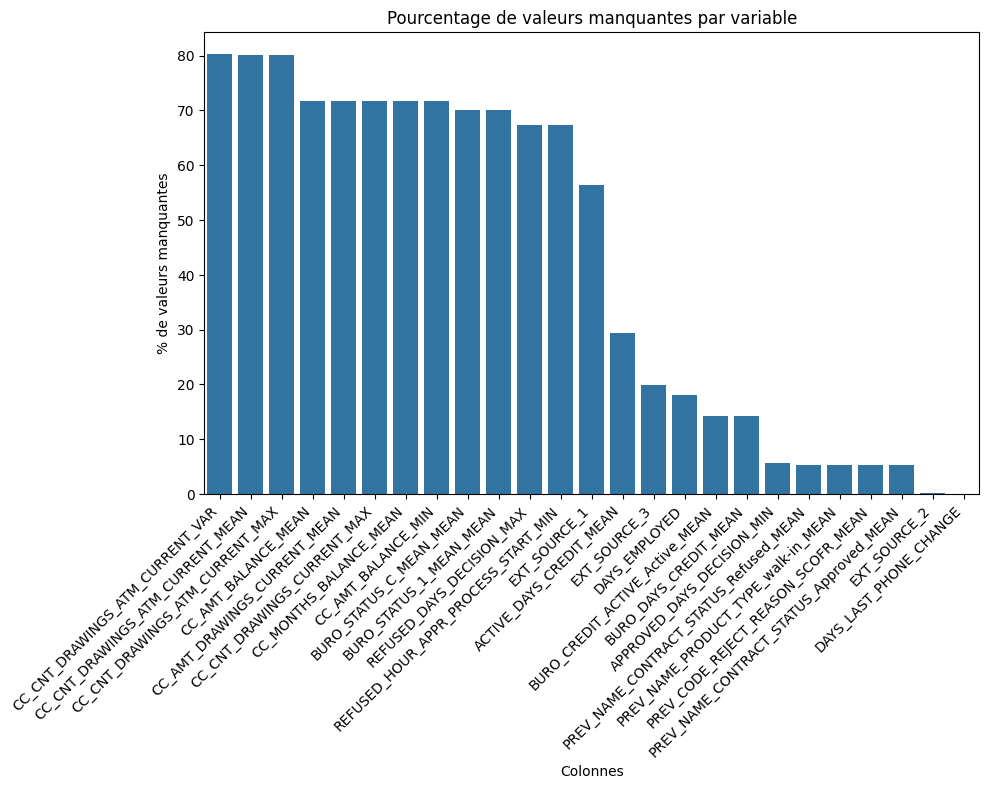

In [18]:
# Configurer la taille de la figure
plt.figure(figsize=(10, 6))

# Créer un diagramme en barres avec Seaborn pour les valeurs manquantes
sns.barplot(x=missing_df_sorted.index, y=missing_df_sorted['% of Total Values'])

# Ajouter des labels et un titre
plt.xticks(rotation=45, ha='right')  # Rotation et alignement des étiquettes de l'axe x
plt.xlabel('Colonnes')
plt.ylabel('% de valeurs manquantes')
plt.title('Pourcentage de valeurs manquantes par variable')

# Afficher le graphique
plt.show()

Avant de passer à la phase d’entraînement des modèles, il sera crucial de traiter les colonnes avec des valeurs manquantes afin de garantir la qualité des données et d'améliorer les performances du modèle.

#### Valeurs nulles

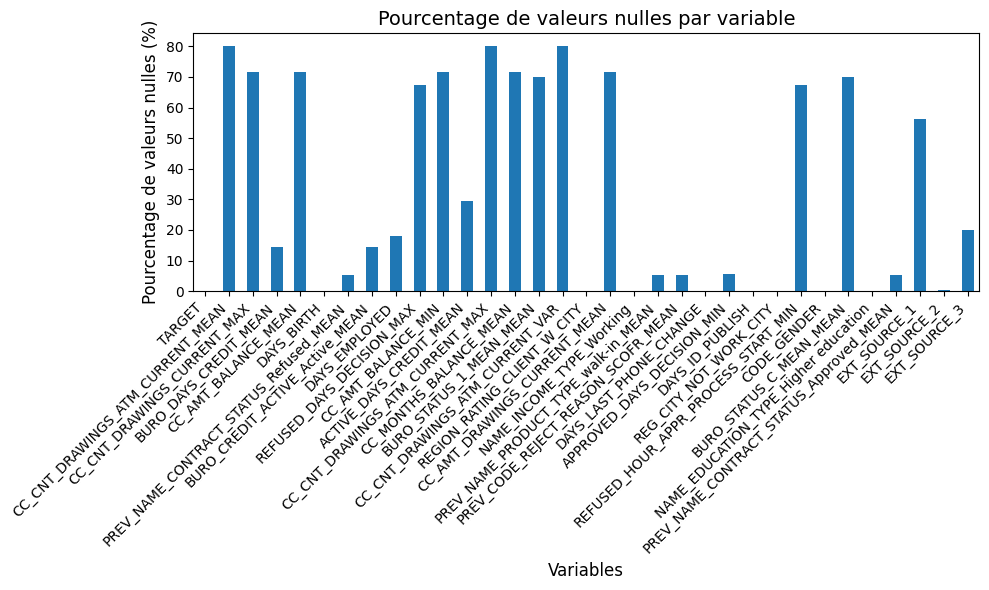

In [20]:
# Calculer le pourcentage de valeurs nulles par colonne
null_percentages = train_df_2.isnull().mean() * 100

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
null_percentages.plot(kind='bar')

# Ajouter des labels et un titre
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Pourcentage de valeurs nulles (%)', fontsize=12)
plt.title('Pourcentage de valeurs nulles par variable', fontsize=14)

# Rotation des labels de l'axe x pour une meilleure lisibilité
plt.xticks(rotation=45, ha='right')

# Afficher le graphique
plt.tight_layout()
plt.show()


## 4. Modèle de prédiction

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import mlflow
import time
from scipy.stats import uniform, randint  # Assurez-vous d'importer ces deux fonctions
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from joblib import dump
from sklearn.metrics import confusion_matrix, roc_auc_score
import mlflow
from scipy.stats import uniform, randint


### 4.1. Prétraitement des données

In [20]:
# Séparation des caractéristiques (X) et de la cible (y) pour l'entraînement
X = train_df_2.drop(columns='TARGET')
y = train_df_2['TARGET']

# Séparation du jeu d'entraînement en entraînement et validation (80% - 20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Séparation de X_temp en validation et test (50% - 50% de l'ensemble temp)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Sélectionner uniquement les colonnes quantitatives (numériques)
quantitative_columns = X_train.select_dtypes(include=[np.number]).columns

# Initialiser l'imputer avec la stratégie 'median'
imputer = SimpleImputer(strategy='median')

# Appliquer l'imputer sur les colonnes quantitatives du jeu d'entraînement et de validation
X_train[quantitative_columns] = imputer.fit_transform(X_train[quantitative_columns])
X_val[quantitative_columns] = imputer.transform(X_val[quantitative_columns])
X_test[quantitative_columns] = imputer.transform(X_test[quantitative_columns])

# Application de SMOTE uniquement sur le jeu d'entraînement pour gérer le déséquilibre des classes
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Standardiser les données avec MinMaxScaler
scaler = MinMaxScaler()

# Appliquer la standardisation sur le jeu d'entraînement, de validation et de test
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Vérification des dimensions
print(f"Dimensions de X_train : {X_train.shape}")
print(f"Dimensions de X_val : {X_val.shape}")
print(f"Dimensions de X_test : {X_test.shape}")

Dimensions de X_train : (452264, 32)
Dimensions de X_val : (30751, 32)
Dimensions de X_test : (30752, 32)


### 4.2. Modélisation

In [21]:
# Fonction pour calculer le score métier
def business_score(y_true, y_pred_proba, threshold=0.5, fn_cost=10, fp_cost=1):
    y_pred = (y_pred_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = (fn * fn_cost) + (fp * fp_cost)
    return total_cost

# Fonction pour évaluer les modèles
def evaluate_model(model, X_train, y_train, X_val, y_val, threshold=0.5):
    start_time = time.time()
    model.fit(X_train, y_train)
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    
    auc_score = roc_auc_score(y_val, y_val_pred_proba)
    business_cost = business_score(y_val, y_val_pred_proba, threshold=threshold)
    exec_time = time.time() - start_time

    return {
        'AUC': auc_score,
        'Business Cost': business_cost,
        'Execution Time': exec_time
    }

# Fonction pour optimiser le seuil
def find_optimal_threshold(model, X_val, y_val, fn_cost=10, fp_cost=1):
    best_threshold = 0.5
    best_cost = float('inf')
    
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    
    for threshold in np.arange(0, 1, 0.01):
        cost = business_score(y_val, y_val_pred_proba, threshold, fn_cost, fp_cost)
        if cost < best_cost:
            best_cost = cost
            best_threshold = threshold
    
    return best_threshold, best_cost

# Modèles à tester
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(eval_metric='auc'),
    'CatBoost': CatBoostClassifier(silent=True),
    'Dummy': DummyClassifier(strategy='stratified')
}

# Paramètres à tester pour chaque modèle avec RandomizedSearchCV
param_dist = {
    'LogisticRegression': {
        'C': uniform(0.01, 10),  
        'solver': ['lbfgs', 'liblinear']
    },
    'LightGBM': {
        'num_leaves': randint(20, 50),
        'learning_rate': uniform(0.01, 0.3),
        'n_estimators': randint(100, 200)
    },
    'XGBoost': {
        'learning_rate': uniform(0.01, 0.3),
        'n_estimators': randint(100, 200),
        'max_depth': randint(3, 10)
    },
    'CatBoost': {
        'depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.3),
        'iterations': randint(100, 200)
    },
    'Dummy': {
        'strategy': ['stratified', 'most_frequent']
    }
}

# DataFrame pour stocker les résultats
results = []


# Initialiser l'expérience MLflow
mlflow.set_experiment('credit_scoring_experiment')

# Boucle sur les modèles
for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        print(f"Optimisation pour {model_name}")
        
        # RandomizedSearchCV pour optimiser les hyperparamètres
        search_cv = RandomizedSearchCV(
            model,
            param_distributions=param_dist[model_name],
            n_iter=10,
            cv=3,
            n_jobs=1,
            random_state=42
        )
        
        search_cv.fit(X_train, y_train)
        best_model = search_cv.best_estimator_
        
        # Enregistrer les hyperparamètres dans MLflow
        mlflow.log_params(search_cv.best_params_)
        
        # Évaluer les métriques
        eval_metrics = evaluate_model(best_model, X_train, y_train, X_val, y_val)
        best_threshold, best_cost = find_optimal_threshold(best_model, X_val, y_val)
        eval_metrics['Optimal Threshold'] = best_threshold
        eval_metrics['Business Cost with Optimal Threshold'] = best_cost
        eval_metrics['Model'] = model_name
        eval_metrics['Best Params'] = search_cv.best_params_
        
        results.append(eval_metrics)
        
        # Enregistrer les métriques dans MLflow
        mlflow.log_metric("AUC", eval_metrics['AUC'])
        mlflow.log_metric("Business Cost", eval_metrics['Business Cost'])
        mlflow.log_metric("Business Cost with Optimal Threshold", best_cost)
        mlflow.log_metric("Execution Time", eval_metrics['Execution Time'])
        
        # Enregistrer le modèle dans MLflow
        mlflow.sklearn.log_model(best_model, model_name)
        
        # Enregistrer dans le Model Registry
        model_uri = f"runs:/{mlflow.active_run().info.run_id}/{model_name}"
        mlflow.register_model(model_uri, "CreditScoringModel")


# Rassembler les résultats dans un DataFrame
df_results = pd.DataFrame(results)
df_results


Optimisation pour LogisticRegression


KeyboardInterrupt: 

Tracking MLFlow: http://127.0.0.1:5000/#/experiments/685302195104521140?viewStateShareKey=f9cbb98e7827c2a2615434cfc5dbc9f9c23b9a6268feed2a3bef82206d68bb20

In [28]:
# Choisir le modèle optimal
optimal_model_name = df_results.loc[df_results['Business Cost'].idxmin(), 'Model']
optimal_model_params = df_results.loc[df_results['Business Cost'].idxmin(), 'Best Params']
print(f"Le modèle optimal est : {optimal_model_name}")
print(f"Meilleurs paramètres : {optimal_model_params}")

# Entraîner le modèle optimal sur l'ensemble d'entraînement complet
if optimal_model_name == 'LogisticRegression':
    best_model = LogisticRegression(**optimal_model_params, max_iter=1000)
elif optimal_model_name == 'LightGBM':
    best_model = LGBMClassifier(**optimal_model_params)
elif optimal_model_name == 'XGBoost':
    best_model = XGBClassifier(**optimal_model_params)
elif optimal_model_name == 'CatBoost':
    best_model = CatBoostClassifier(**optimal_model_params, silent=True)

best_model.fit(X_train, y_train)

# Prédictions sur le jeu de test
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Utiliser le seuil optimal
optimal_threshold = df_results.loc[df_results['Model'] == optimal_model_name, 'Optimal Threshold'].values[0]
y_test_pred = (y_test_pred_proba >= optimal_threshold).astype(int)

# Évaluer les performances sur le jeu de test
auc_test = roc_auc_score(y_test, y_test_pred_proba)
test_business_cost = business_score(y_test, y_test_pred_proba, threshold=optimal_threshold)

print(f"AUC sur le jeu de test : {auc_test}")
print(f"Coût métier sur le jeu de test : {test_business_cost}")

Le modèle optimal est : LogisticRegression
Meilleurs paramètres : {'C': 4.468327528535911, 'solver': 'lbfgs'}
AUC sur le jeu de test : 0.7476821006773295
Coût métier sur le jeu de test : 16754


### 4.3. Importances globale et locale

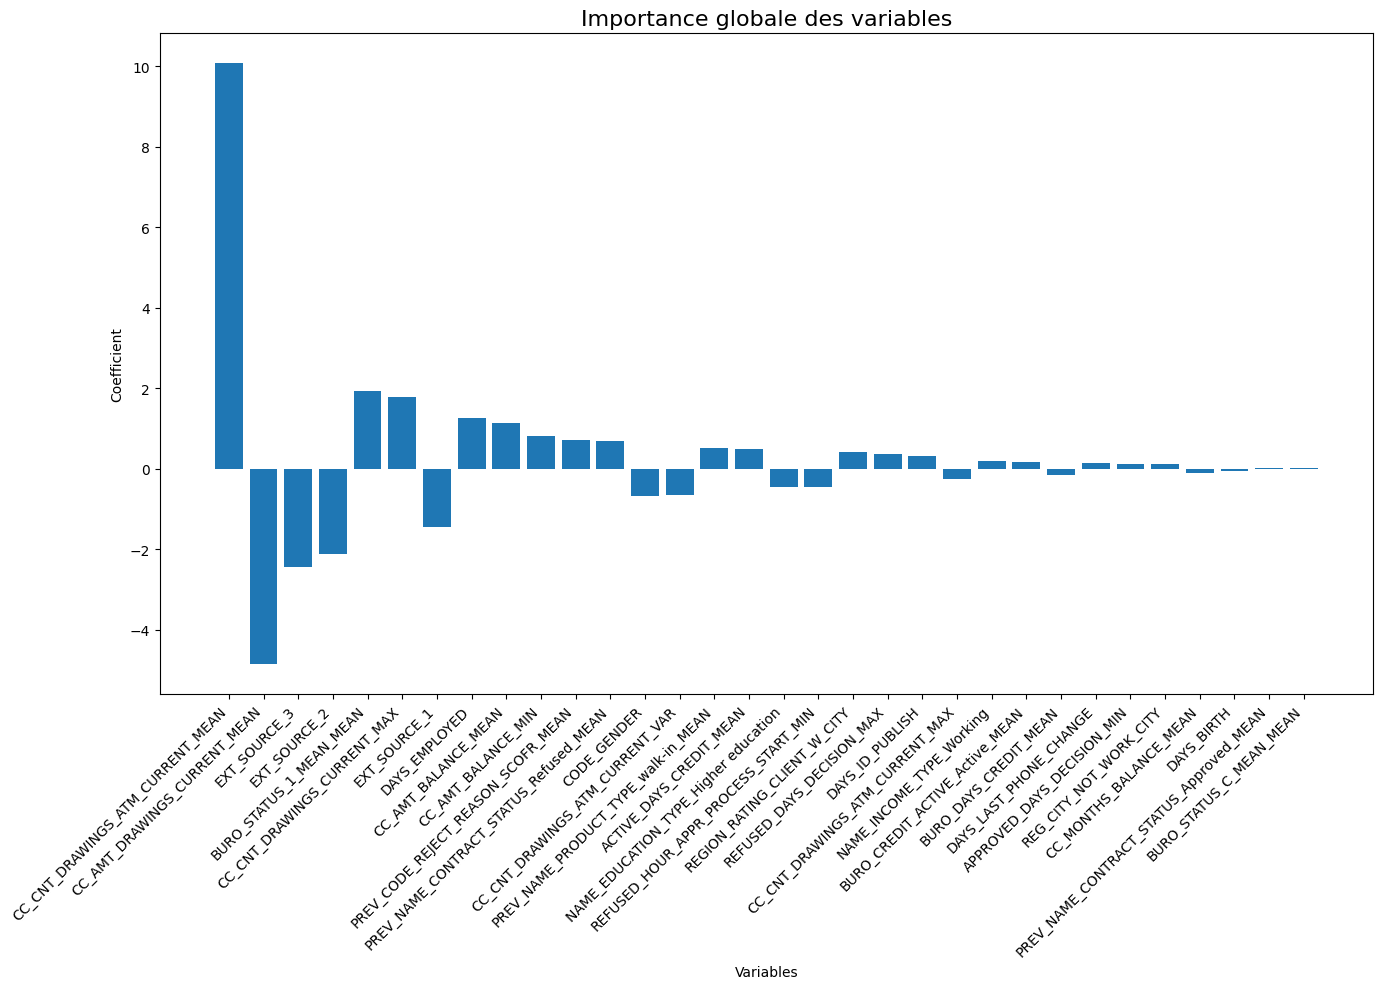

In [29]:
#Importance globale
# Récupérer les coefficients du modèle
coefficients = best_model.coef_[0]  # Les coefficients pour chaque caractéristique
features = X_train.columns if isinstance(X_train, pd.DataFrame) else quantitative_columns

# Trier les coefficients par importance absolue
indices = np.argsort(np.abs(coefficients))[::-1]

# Tracer l'importance des variables
plt.figure(figsize=(14, 10))
plt.title("Importance globale des variables", fontsize=16)
plt.bar(range(len(coefficients)), coefficients[indices], align="center")
plt.xticks(range(len(coefficients)), [features[i] for i in indices], rotation=45, ha="right")
plt.xlabel("Variables")
plt.ylabel("Coefficient")
plt.tight_layout()
plt.show()


Interprétation :
Les coefficients positifs signifient que la variable a un effet positif sur la probabilité de l'événement cible (c'est-à-dire, elle augmente la probabilité d'une prédiction positive).
Les coefficients négatifs signifient que la variable réduit la probabilité de l'événement cible.
La valeur absolue des coefficients indique l'importance des variables.

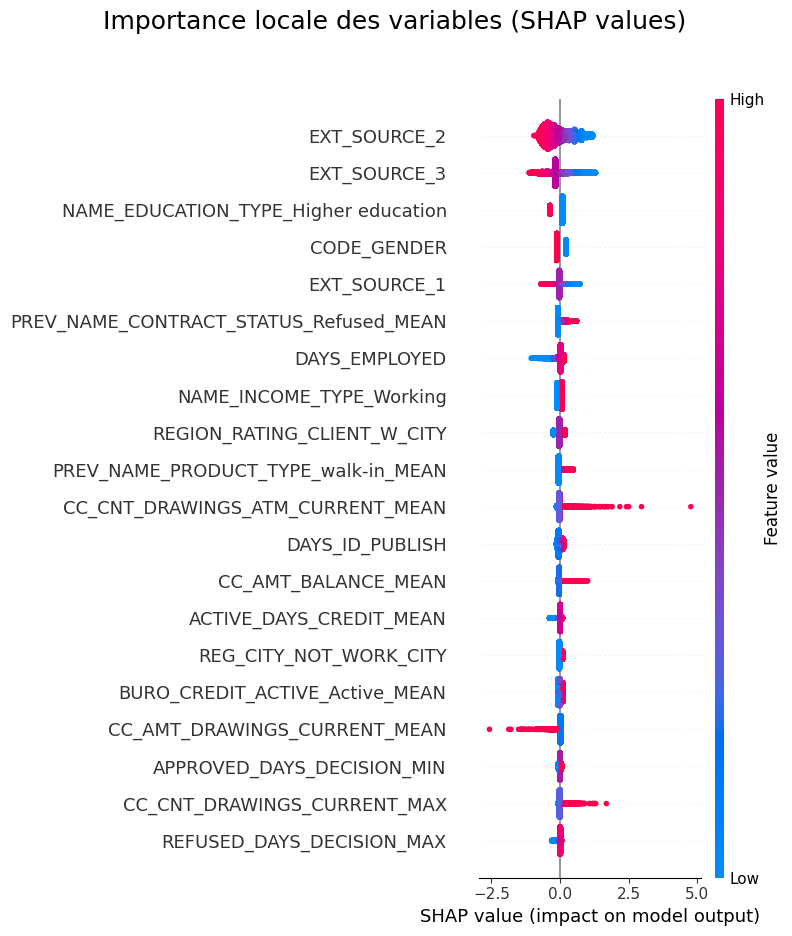

In [30]:
#Importance locale 
import shap

# Créer un explainer SHAP pour le modèle LogisticRegression
explainer = shap.LinearExplainer(best_model, X_train)  # Utilise l'explicateur linéaire pour la régression logistique

# Calculer les valeurs SHAP pour le jeu de test
shap_values = explainer.shap_values(X_test)

# Créer une nouvelle figure
plt.figure(figsize=(10, 6))

# Afficher le résumé SHAP global (mélange entre importance globale et locale)
shap.summary_plot(shap_values, X_test, feature_names=quantitative_columns, show=False)

# Ajouter un titre centré avec du padding pour éviter les décalages
plt.suptitle("Importance locale des variables (SHAP values)", x=0.5, ha='center', fontsize=18)

# Ajuster le layout pour éviter les chevauchements
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Afficher la figure
plt.show()

Globalement, les variables les plus importantes sont celles en haut du graphique.
Localement, chaque point montre l'impact d'une variable spécifique pour un individu donné, ce qui permet de voir comment les valeurs individuelles affectent les prédictions du modèle.

Valeurs SHAP (axe horizontal) :
L'axe des abscisses (X) représente les valeurs SHAP. Plus la valeur SHAP d'une variable est éloignée de zéro, plus cette variable a un fort impact sur la prédiction (positivement ou négativement).
Les points à droite (valeurs SHAP positives) indiquent que la variable a contribué à augmenter la probabilité du modèle de prédire la classe positive.
Les points à gauche (valeurs SHAP négatives) indiquent que la variable a contribué à diminuer cette probabilité.

Couleurs des points :
Chaque point représente une observation (un individu du jeu de test).
La couleur des points indique la valeur de la variable pour cet individu :
Rouge = Valeurs élevées de la variable.
Bleu = Valeurs basses de la variable.
Par exemple, pour la variable EXT_SOURCE_2, on observe que des valeurs élevées ont tendance à réduire la probabilité du modèle de prédire la classe positive (les points rouges sont vers la gauche).

EXT_SOURCE_2 et EXT_SOURCE_3 : Ces deux variables semblent être les plus influentes. Les points rouges sont principalement situés à gauche, indiquant que des valeurs élevées réduisent les prédictions positives.
NAME_EDUCATION_TYPE_Higher education : On voit que cette variable a un effet varié. Des valeurs élevées (rouge) ont tendance à augmenter la probabilité de la classe positive.
CODE_GENDER : La couleur semble indiquer que le genre a un certain impact, mais cet impact est moins marqué que celui des autres variables plus haut dans la liste.

Le graphique montre que certaines variables, notamment EXT_SOURCE_2, EXT_SOURCE_3, et le niveau d'éducation, jouent un rôle clé dans les décisions du modèle.

In [31]:
import joblib

# Sauvegarder le modèle dans un fichier
joblib.dump(best_model, 'logistic_regression_model.pkl')

In [32]:
#import joblib
#joblib.dump(best_model, 'model.joblib')

In [33]:
#import pickle

# Enregistrer le modèle
#with open('best_logistic_model.pkl', 'wb') as model_file:
    #pickle.dump(best_model, model_file)


In [38]:
# Filtrer la ligne pour LogisticRegression
logreg_params_row = df_results[df_results['Model'] == 'LogisticRegression']
best_params_lr = logreg_params_row['Best Params'].values[0]
    
# Filtrer les paramètres pour ne garder que ceux qui sont valides pour LogisticRegression
valid_params_lr = {key: value for key, value in best_params_lr.items() 
                       if key in ['C', 'solver', 'penalty', 'max_iter']}
    
print(f"Valid Params for LogisticRegression: {valid_params_lr}")
    
# Créer le pipeline avec les bons hyperparamètres
pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # Imputation des valeurs manquantes
        ('scaler', MinMaxScaler()),  # Standardisation des données
        ('classifier', LogisticRegression(**valid_params_lr))  # Modèle avec les paramètres filtrés
    ])
    
# Ajuster le pipeline sur les données d'entraînement
pipeline.fit(X_train, y_train)
    
# Évaluer le modèle sur le jeu de validation
y_val_pred_proba = pipeline.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_val_pred_proba)
print(f"AUC: {auc_score}")

# Optimisation du seuil et calcul des métriques métier
optimal_threshold, business_cost = find_optimal_threshold(pipeline, X_val, y_val)
print(f"Optimal Threshold: {optimal_threshold}, Business Cost: {business_cost}")

Valid Params for LogisticRegression: {'C': 4.468327528535911, 'solver': 'lbfgs'}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.7421277228289095
Optimal Threshold: 0.52, Business Cost: 17000


In [39]:
import mlflow
import mlflow.sklearn

# Initialiser une expérience dans MLflow
mlflow.set_experiment('logistic_regression_pipeline')

with mlflow.start_run(run_name='LogisticRegression with Best Params'):
    
    # Enregistrer les hyperparamètres dans MLflow
    mlflow.log_params(valid_params_lr)
    
    # Ajuster le pipeline sur les données d'entraînement
    pipeline.fit(X_train, y_train)
    
    # Évaluer le modèle sur le jeu de validation
    y_val_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_val_pred_proba)
    print(f"AUC: {auc_score}")
    
    # Optimisation du seuil et calcul des métriques métier
    optimal_threshold, business_cost = find_optimal_threshold(pipeline, X_val, y_val)
    print(f"Optimal Threshold: {optimal_threshold}, Business Cost: {business_cost}")
    
    # Enregistrer les métriques dans MLflow
    mlflow.log_metric('AUC', auc_score)
    mlflow.log_metric('Optimal Threshold', optimal_threshold)
    mlflow.log_metric('Business Cost', business_cost)
    
    # Enregistrer le pipeline dans MLflow
    mlflow.sklearn.log_model(pipeline, "logistic_regression_pipeline")
    
    # Finir le run
    mlflow.end_run()

print("Modèle et métriques enregistrés dans MLflow avec succès.")


2024/10/08 19:01:01 INFO mlflow.tracking.fluent: Experiment with name 'logistic_regression_pipeline' does not exist. Creating a new experiment.
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.7421277228289095
Optimal Threshold: 0.52, Business Cost: 17000


2024/10/08 19:01:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle et métriques enregistrés dans MLflow avec succès.


In [40]:
import joblib

In [41]:
joblib.dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']

In [42]:
from mlflow.models.signature import infer_signature

In [43]:
signature = infer_signature(X_train, y_train)

/opt/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [44]:
import mlflow.sklearn

In [45]:
mlflow.sklearn.save_model(pipeline, 'mlflow_model', signature=signature)